In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
print(tf.config.list_logical_devices('GPU'))

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [ ]:
vocab_size = 10000
max_len = 200
embedding_dim = 64
num_heads = 2
d_model = 128
dff = 512
num_encoder_layer = 2
batch_size = 32
num_epochs = 10
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size, seed=123)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [ ]:
print(x_train.shape, y_train.shape)

(15000, 200) (15000,)


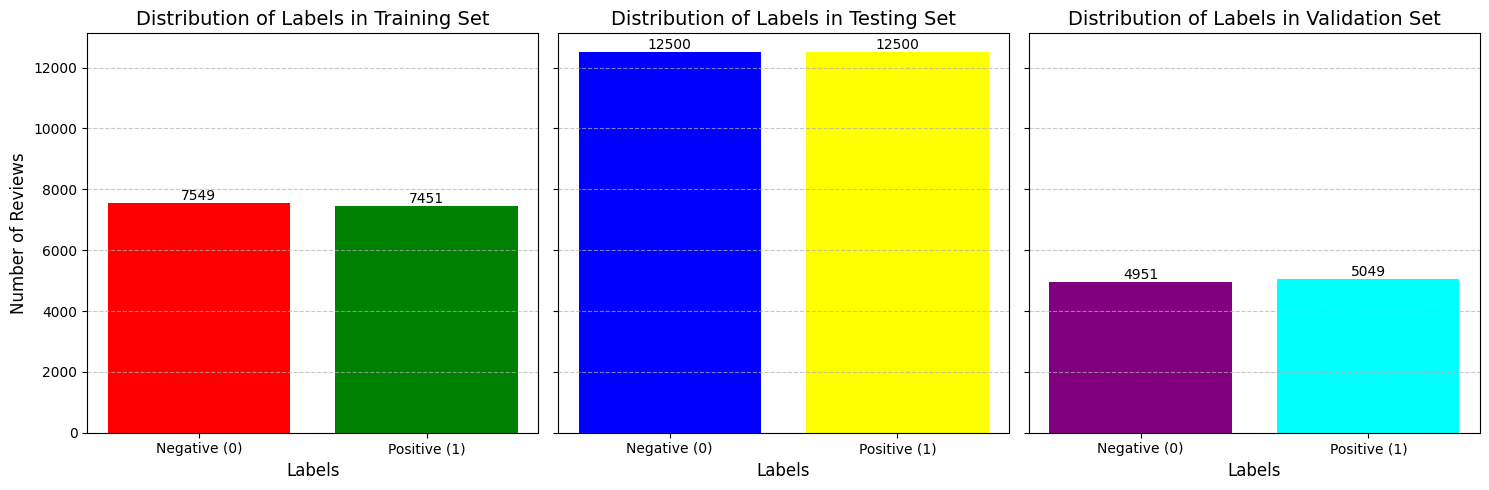

In [ ]:
train_label_counts = np.bincount(y_train)
test_label_counts = np.bincount(y_test)
val_label_counts = np.bincount(y_val)
def plot_multiple_label_distributions(label_counts_list, titles, colors_list):
    num_plots = len(label_counts_list)
    fig, axes = plt.subplots(1, num_plots, figsize=(15, 5), sharey=True)
    labels = ['Negative (0)', 'Positive (1)']
    for i, (label_counts, title, colors) in enumerate(zip(label_counts_list, titles, colors_list)):
        axes[i].bar(labels, label_counts, color=colors)
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel('Labels', fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        for j, count in enumerate(label_counts):
            axes[i].text(j, count + 100, str(count), ha='center', fontsize=10)
    axes[0].set_ylabel('Number of Reviews', fontsize=12)
    plt.tight_layout()
    plt.show()
plot_multiple_label_distributions(
    label_counts_list=[train_label_counts, test_label_counts, val_label_counts],
    titles=[
        "Distribution of Labels in Training Set",
        "Distribution of Labels in Testing Set",
        "Distribution of Labels in Validation Set"
    ],
    colors_list=[
        ['red', 'green'],
        ['blue', 'yellow'],
        ['purple', 'cyan']
    ]
)

In [ ]:
print(x_test.shape, y_test.shape)

(25000, 200) (25000,)


In [ ]:
def scaled_dot_product(q, k, v):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    depth = tf.cast(tf.shape(k)[-1], tf.float32)
    logits = matmul_qk/tf.math.sqrt(depth)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model%num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_head(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v):
        batch_size = tf.shape(q)[0]
        q, k, v = self.wq(q), self.wk(k), self.wv(v)
        q, k, v = self.split_head(q, batch_size), self.split_head(k, batch_size),self.split_head(v, batch_size)
        scaled_attention = scaled_dot_product(q, k, v)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output

In [ ]:
def point_wise_feedforward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation="relu"),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayers(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayers, self).__init__()
        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feedforward_network(d_model=d_model, dff=dff)
        self.layerNorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layerNorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate=rate)
        self.dropout2 = tf.keras.layers.Dropout(rate=rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layerNorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layerNorm2(ffn_output + out1)
        return out2

In [ ]:
import numpy as np
def positional_encoding(position, d_model):
    def get_angles(pos, i, d_model):
        angle_rates = 1/np.power(10000, (2*i//np.float32(d_model)))
        return pos * angle_rates
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model=d_model)
    angle_rads[: ,0::2] = np.sin(angle_rads[: ,0::2])
    angle_rads[: ,1::2] = np.cos(angle_rads[: ,1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class TranformerClassifier(tf.keras.Model):
    def __init__(self, num_encoder_layer, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding, rate=0.1):
        super(TranformerClassifier, self).__init__()
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model=d_model)
        self.enc_layers = [EncoderLayers(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_encoder_layer)]
        self.drop_out = tf.keras.layers.Dropout(rate=rate)
        self.global_average_poolimg = GlobalAveragePooling1D()
        self.final_layer = Dense(1, activation="sigmoid")

    def call(self, x, training):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.drop_out(x, training=training)
        for i in range(num_encoder_layer):
            x = self.enc_layers[i](x, training=training)
        x = self.global_average_poolimg(x)
        return self.final_layer(x)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath="best_model_weights.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
model = TranformerClassifier(num_encoder_layer=num_encoder_layer, d_model=d_model,
                             num_heads=num_heads, dff=dff, input_vocab_size=vocab_size,
                             maximum_position_encoding=max_len)
model.compile(optimizer= Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_val, y_val), callbacks=[checkpoint])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.5284 - loss: 0.7287
Epoch 1: val_loss improved from inf to 0.37812, saving model to best_model_weights.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - binary_accuracy: 0.5285 - loss: 0.7285 - val_binary_accuracy: 0.8312 - val_loss: 0.3781
Epoch 2/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.8567 - loss: 0.3406
Epoch 2: val_loss improved from 0.37812 to 0.30671, saving model to best_model_weights.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - binary_accuracy: 0.8568 - loss: 0.3404 - val_binary_accuracy: 0.8708 - val_loss: 0.3067
Epoch 3/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.9203 - loss: 0.2065
Epoch 3: val_loss did not improve from 0.30671
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - binary_accuracy: 0.9203 - loss: 0.2065 - val_binary_accuracy: 0.8709 - val_loss: 0.3372
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.9495 - l

In [ ]:
model.load_weights("best_model_weights.weights.h5")
test_loss, acc_loss = model.evaluate(x_test, y_test)
print(f"Best Test Loss: {test_loss}")
print(f"Best Test Accuracy: {acc_loss}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8714 - loss: 0.3028
Best Test Loss: 0.30667662620544434
Best Test Accuracy: 0.8693199753761292


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


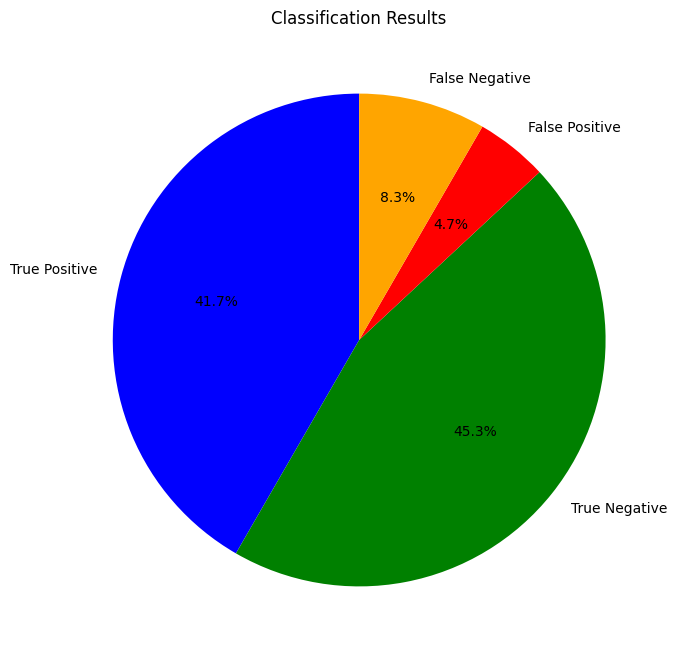

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).flatten()
true_positive = np.sum((y_test == 1) & (y_pred == 1))
true_negative = np.sum((y_test == 0) & (y_pred == 0))
false_positive = np.sum((y_test == 0) & (y_pred == 1))
false_negative = np.sum((y_test == 1) & (y_pred == 0))
labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
values = [true_positive, true_negative, false_positive, false_negative]
colors = ['blue', 'green', 'red', 'orange']
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Classification Results")
plt.show()